# Analysis of the Stack Overflow Developer Survey Dataset

## Focus of the Analysis

I want to analyze how Salary contributes to Job Satisfaction 

In [1]:
# import python modules
import pandas as pd
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import numpy as np

# Step 1: Load the data and get an overview

In [2]:
# load the dataset
# Dataset downloaded from: https://www.kaggle.com/datasets/stackoverflow/so-survey-2017
df = pd.read_csv(os.path.join('data','survey_results_public.csv'))

df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
#shape of the data
print(df.shape)

(51392, 154)


In [127]:
#how many countrys
print(len(df['Country'].unique()))

201


## Step 2: Narrow down the data

I want to narrwo the data down to the columns I selected from reading the documentation on Kaggle (https://www.kaggle.com/datasets/stackoverflow/so-survey-2017) 

In [3]:
cols_to_use = ['JobSatisfaction','Country','HomeRemote','CompanySize','CompanyType','DeveloperType','YearsCodedJob','Salary','EmploymentStatus','ProgramHobby','CareerSatisfaction','LastNewJob','WorkPayCare','KinshipDevelopers','Gender','Professional']

dev_subset = df[cols_to_use].copy()

And I want to narrow the data down to professional developers with some kind of employment

In [4]:
# I want to narrow the data down to respondends with some kind of employment
print(dev_subset['EmploymentStatus'].unique())

['Not employed, and not looking for work' 'Employed part-time'
 'Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Not employed, but looking for work' 'I prefer not to say' 'Retired']


In [5]:
relevant_employment_status = ['Employed full-time','Employed part-time','Independent contractor, freelancer, or self-employed']

In [6]:
# Limit the dataset to the answers from professional developers that are employed
dev_subset = dev_subset[(dev_subset['Professional'] == 'Professional developer') & (dev_subset['EmploymentStatus'].isin(relevant_employment_status))]

#Drop the Professional column
dev_subset = dev_subset.drop(columns=['Professional'])

#check how much of the data are within this group of respondents
print('The proportion of working professional developers in the dataset is:',(len(dev_subset)/len(df)))

The proportion of working professional developers in the dataset is: 0.6873832503113325


The subset I choose, contains 69% of all respondents. I think this in big enough to get good results 

## Step 3: Understand the Data


In [7]:
print(dev_subset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              12891 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB
None


The Columns JobSatisfaction, Salary and CareerSatiafaction are numerical columns. All other features are cathegorical. 

Also The Salary column has a lot of missing values that needs imputing. 

In [8]:
# take a closer look at numerical features
dev_subset.describe()

,JobSatisfaction,Salary,CareerSatisfaction
count,34955.000000,12891.000000,35023.000000
mean,7.009612,56298.480641,7.447106
std,2.141212,39880.905277,1.824708
min,0.000000,0.000000,0.000000
25%,6.000000,26440.371839,7.000000
50%,7.000000,50000.000000,8.000000
75%,8.000000,80000.000000,9.000000
max,10.000000,197000.000000,10.000000


Text(0, 0.5, 'count')

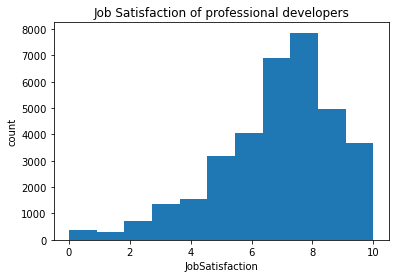

In [128]:
# plot data
plt.plot()
plt.hist(dev_subset['JobSatisfaction'],bins=11)
plt.title('Job Satisfaction of professional developers')
plt.xlabel('JobSatisfaction')
plt.ylabel('count')

Text(0, 0.5, 'count')

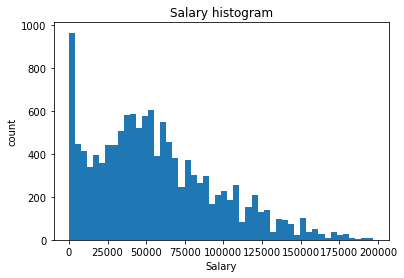

In [10]:
# plot data
plt.plot()
plt.hist(dev_subset['Salary'],bins=50)
plt.title('Salary histogram')
plt.xlabel('Salary')
plt.ylabel('count')

<AxesSubplot:xlabel='JobSatisfaction', ylabel='Salary'>

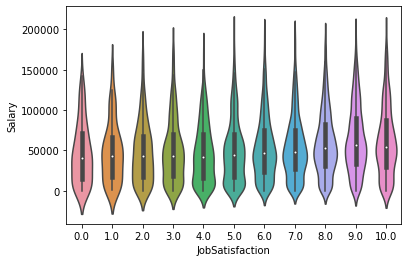

In [11]:
# plot data
sns.violinplot(data=dev_subset, x="JobSatisfaction", y="Salary")

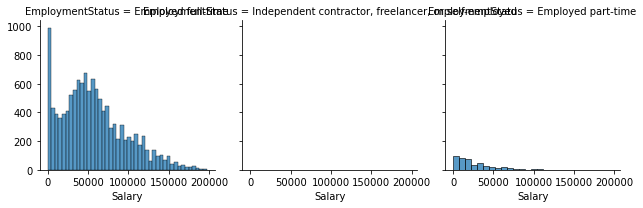

In [12]:
g = sns.FacetGrid(dev_subset, col="EmploymentStatus")
g.map(sns.histplot, "Salary")

This plot shows, that by dropping the rows with the missing salary information would lead to eliminating all the self-employed respondends form the dataset althought we do not even know jet, how much Salary contributes to the Job satisfaction. 

When we compare the salay plots for the Full-time and half-time employed respondends, we see, that using the mean is also not a good choice.

## Step 4: Prepare the Data

We need to clean the data (=handling missing values), split in X and y and split in a train set and a test set. As I will need to do this multiple times, I will prepare functions for all the relevant steps

In [13]:
def GetDummyColumns(X): 

    # Dummy columns for the categorical variables
    cat_vars = X.select_dtypes(include=['object']).copy().columns
    
    X_dummy = X[cat_vars]
    
    for var in  cat_vars:
        
        dummy_df = pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)
        
        X_dummy = pd.concat([X_dummy.drop(var, axis=1), dummy_df], axis=1)
    
    return X_dummy

def GetReducedFeatureList(X): 
    # This function returns a list of all features, where the feature is present in over 0,1 % of the dataset
    # The aim is to limit the dataset to only relevant features
    # this method applies only for dummy columns
    
    #get the mean of each column
    X_perc=X.mean()

    reduced_feature_list = X_perc[X_perc >= 0.001].index
    
    return(reduced_feature_list)

def ImputeNumericalValues(X): 
    # Fill numeric columns with the mean
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    
    X_num = X[num_vars]
    
    for col in num_vars:
        
            X_num[col].fillna((X_num[col].mean()), inplace=True)
    
    return(X_num)

def clean_data(X,reduce_features = True): 
    # This function imputes numeric columns in the dd with the mean and introduces dummy columns for categorical columns
        
    X_dummy = GetDummyColumns(X)
    
    if reduce_features:
        
        reduced_feature_list = GetReducedFeatureList(X_dummy)
        
        X_dummy = X_dummy[reduced_feature_list]
    
    X_num = ImputeNumericalValues(X)
    
    X_new = pd.concat([X_num,X_dummy],axis=1)
    
    return X_new

def GetLinearRegressionInput(df, y_col): 
    
    df_new = df.dropna(subset=[y_col])
    
    X = clean_data(df_new.drop(columns=y_col)) 
    
    y = df_new[y_col]
    
    return(X,y)

### How do we impute the missing values in the salary colum

I want to try out two different ways of handling the missing values in the salary column. therefore, I will treat the salary column differently, than the other numerical columns. I will create 3 versions of the dev_subset. In each version, a different imputing strategy for the salary column is used. 

I will use the following strategies: 

1) Droping the rows with missing values
2) Imputing with the median of the dataset
3) using a linear model to predict the missing Salary columns and then use this model to fill the columns

#### Version 1 

Droping the rows with missing Salary

In [14]:
dev_subset_1 = dev_subset.dropna(subset=['Salary'])

dev_subset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12891 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     12852 non-null  float64
 1   Country             12891 non-null  object 
 2   HomeRemote          12883 non-null  object 
 3   CompanySize         12880 non-null  object 
 4   CompanyType         12868 non-null  object 
 5   DeveloperType       12889 non-null  object 
 6   YearsCodedJob       12834 non-null  object 
 7   Salary              12891 non-null  float64
 8   EmploymentStatus    12891 non-null  object 
 9   ProgramHobby        12891 non-null  object 
 10  CareerSatisfaction  12861 non-null  float64
 11  LastNewJob          9078 non-null   object 
 12  WorkPayCare         8874 non-null   object 
 13  KinshipDevelopers   8817 non-null   object 
 14  Gender              11709 non-null  object 
dtypes: float64(3), object(12)
memory usage: 1.6+ MB


In [15]:
#clean the data of dev_subset_1
X_1,y_1 = GetLinearRegressionInput(dev_subset_1, y_col='JobSatisfaction')

print('Salary' in X_1.columns)

X_1.shape

True


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(12852, 219)

#### Version 2

Imputing the missing Salary values with the mean. 

In [16]:
# preparing a subset where all missing salary information are filled with the median salary 
dev_subset_2 = dev_subset.copy()

dev_subset_2['Salary'].fillna(dev_subset_2['Salary'].median(), inplace=True)

dev_subset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51390
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              35326 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 5.3+ MB


In [17]:
#clean the data of dev_subset_1
X_2,y_2 = GetLinearRegressionInput(dev_subset_2, y_col='JobSatisfaction')

print('Salary' in X_2.columns)

X_2.shape

True


(34955, 235)

#### Version 3

Use a Linear regression model to predict the missing values in the salary column

In [87]:
def perform_linear_regression(X,y,normal): 
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    
    lm_model = LinearRegression(normalize=normal) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test



In [88]:
# To predict the Salary column, we do not wan to use JobSatisfaction column
subset_fit_salary = dev_subset.drop(columns='JobSatisfaction')
print(subset_fit_salary.shape)

missing_salary_mask = subset_fit_salary['Salary'].notna()

# train the linear model on the subset with salaries

X_reg, y_reg = GetLinearRegressionInput(subset_fit_salary,y_col='Salary')

Res = perform_linear_regression(X_reg, y_reg,normal=False)

print('test score:',Res[0])
print('train score:',Res[1])

print(Res[3].shape)

lm_model = Res[2]

(35326, 14)
test score: 0.7203227057227752
train score: 0.72998119364112
(9023, 218)


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [89]:
#coefficient dataframe
coeffs = pd.Series(Res[2].coef_, index=X_reg.columns).sort_values(ascending = False)
coeffs= coeffs.reset_index()

coeffs

,index,0
0,Country_United States,55424.723048
1,Country_Switzerland,54619.732160
2,YearsCodedJob_20 or more years,38969.853260
3,YearsCodedJob_18 to 19 years,35910.270030
4,YearsCodedJob_19 to 20 years,35622.235639
...,...,...
213,Country_Philippines,-17301.643818
214,Country_India,-17915.398078
215,Country_Russian Federation,-18421.779074
216,Country_Pakistan,-20366.322569


In [90]:
# get X that matches the subset with missing salary to fit salary
X_pred = clean_data(subset_fit_salary,reduce_features=False)

X_pred = X_pred[X_reg.columns][~missing_salary_mask]

y_predict = lm_model.predict(X_pred)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [92]:
# fill the misssing Salaries with the predicted one

dev_subset_3_w_salary = dev_subset[missing_salary_mask].copy()

dev_subset_3_wo_salary = dev_subset[~missing_salary_mask].copy()

dev_subset_3_wo_salary.loc[:,'Salary'] =y_predict

dev_subset_3 = pd.concat([dev_subset_3_w_salary,dev_subset_3_wo_salary])

dev_subset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51389
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              35326 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB


<AxesSubplot:>

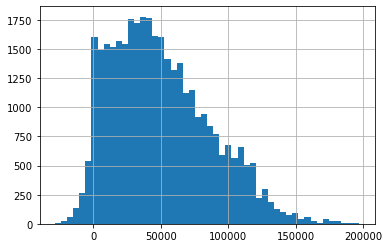

In [93]:
dev_subset_3['Salary'].hist(bins=50)

#how many Salaries were predicted below 0
#(y_predict <= 0).sum()

We can see, that the regression returned negative Salaries. I will replace them with a Salay of 0 as the original Dataset also contains Salaries of 0

In [94]:
dev_subset['Salary'].min()

0.0

In [95]:
dev_subset_3['Salary'][dev_subset_3['Salary'] < 0] = 0.0 

<ipython-input-95-348fa4654d56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_subset_3['Salary'][dev_subset_3['Salary'] < 0] = 0.0


<AxesSubplot:>

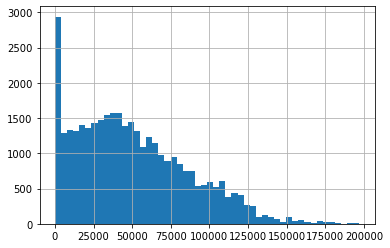

In [96]:
dev_subset_3['Salary'].hist(bins=50)

In [97]:
dev_subset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35326 entries, 2 to 51389
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   JobSatisfaction     34955 non-null  float64
 1   Country             35326 non-null  object 
 2   HomeRemote          35281 non-null  object 
 3   CompanySize         31595 non-null  object 
 4   CompanyType         31528 non-null  object 
 5   DeveloperType       35317 non-null  object 
 6   YearsCodedJob       35051 non-null  object 
 7   Salary              35326 non-null  float64
 8   EmploymentStatus    35326 non-null  object 
 9   ProgramHobby        35326 non-null  object 
 10  CareerSatisfaction  35023 non-null  float64
 11  LastNewJob          23184 non-null  object 
 12  WorkPayCare         22102 non-null  object 
 13  KinshipDevelopers   21916 non-null  object 
 14  Gender              25599 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.3+ MB


Salary histogram looks normal. We can use this for our dataset 3

In [98]:
#clean the data of dev_subset_3
X_3,y_3 = GetLinearRegressionInput(dev_subset_3, y_col='JobSatisfaction')

print('Salary' in X_3.columns)

X_3.shape

True


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(34955, 235)

## Step 5: Model the data

### Linear regression on dev_subset_1

In [28]:
#perform linear regression
Res_1 = perform_linear_regression(X_1, y_1,normal=False)

print('test score:',Res_1[0])
print('train score:',Res_1[1])

test score: 0.3728377737269323
train score: 0.42376536838097945


In [29]:
#coefficient dataframe
coeffs_1 = pd.Series(Res_1[2].coef_, index=X_1.columns).sort_values(ascending = False)
coeffs_1= coeffs_1.reset_index()
salary_index = coeffs_1[coeffs_1['index'] =='Salary'].index[0]
salary_coeff = coeffs_1[coeffs_1['index'] =='Salary'].values[0]

print(f'{salary_index}/{len(coeffs_1)}')
print(salary_coeff)

121/219
['Salary' 1.995864032076433e-06]


### Linear Regression on dev_subset_2

In [30]:
#perform linear regression
Res_2 = perform_linear_regression(X_2, y_2,normal=False)

print('test score:',Res_2[0])
print('train score:',Res_2[1])

test score: 0.4075599375504799
train score: 0.42863542477582917


In [31]:
#coefficient dataframe
coeffs_2 = pd.Series(Res_2[2].coef_, index=X_2.columns).sort_values(ascending = False)
coeffs_2= coeffs_2.reset_index()
salary_index = coeffs_2[coeffs_2['index'] =='Salary'].index[0]
salary_coeff = coeffs_2[coeffs_2['index'] =='Salary'].values[0]

print(f'{salary_index}/{len(coeffs_2)}')
print(salary_coeff)

128/235
['Salary' 3.9714351185528225e-07]


### Linear Regression on dev_subset_3

In [99]:
#perform linear regression
Res_3 = perform_linear_regression(X_3, y_3,normal=False)

print('test score:',Res_3[0])
print('train score:',Res_3[1])

test score: 0.4204808000438004
train score: 0.42338981811516196


In [100]:
#coefficient dataframe
coeffs_3 = pd.Series(Res_3[2].coef_, index=X_3.columns).sort_values(ascending = False)
coeffs_3= coeffs_3.reset_index()
salary_index = coeffs_3[coeffs_3['index'] =='Salary'].index[0]
salary_coeff = coeffs_3[coeffs_3['index'] =='Salary'].values[0]

print(coeffs.head(15))

print(f'{salary_index}/{len(coeffs_3)}')
print(salary_coeff)

                             index             0
0            Country_United States  55424.723048
1              Country_Switzerland  54619.732160
2   YearsCodedJob_20 or more years  38969.853260
3     YearsCodedJob_18 to 19 years  35910.270030
4     YearsCodedJob_19 to 20 years  35622.235639
5     YearsCodedJob_12 to 13 years  34910.263000
6     YearsCodedJob_17 to 18 years  34909.011822
7                   Country_Norway  34411.831451
8     YearsCodedJob_15 to 16 years  32507.684028
9     YearsCodedJob_14 to 15 years  31025.606193
10               Country_Australia  30542.531199
11    YearsCodedJob_16 to 17 years  29948.062531
12    YearsCodedJob_13 to 14 years  28119.505074
13                 Country_Ireland  26830.348584
14    YearsCodedJob_10 to 11 years  25529.427573
134/235
['Salary' 7.028293275460535e-07]


We can see, that the more work we put into imputing the missing salary values, the closer our test_score is to our train_score. So it seems to make a difference. But for all options, the salary coefficient seems to be pretty low and also very much in the back, when we sort the coefficients in descending order.  I would not have expected that to be honest. So lets take a minute and think about if this is the result that actually resembles the information from the data or if our data preparation could have caused this outcome.  

If we look at our original dataset, most of the columns where ordinary and transformed with dummy columns in the data preparation process. This leads to a value that is either 0 or 1. But what about our numerical columns? 

In [101]:
dev_subset_3.describe()

,JobSatisfaction,Salary,CareerSatisfaction
count,34955.000000,35326.000000,35023.000000
mean,7.009612,50236.567884,7.447106
std,2.141212,36268.141750,1.824708
min,0.000000,0.000000,0.000000
25%,6.000000,21343.552213,7.000000
50%,7.000000,44598.644324,8.000000
75%,8.000000,73730.186079,9.000000
max,10.000000,197000.000000,10.000000


We can see, that the salary ranges from 197k to 0. This range is much bigger, than the 0-1 of the categorical values. This could be the reason for the very low coefficient of Salary. To avoid this, we need to implement rescaling to scale the Salary columns to 0-1. 

(array([2939., 1290., 1326., 1318., 1405., 1357., 1436., 1478., 1541.,
        1570., 1569., 1393., 1451., 1323., 1087., 1231., 1152.,  975.,
         894.,  953.,  845.,  745.,  753.,  539.,  546.,  588.,  520.,
         601.,  382.,  433.,  412.,  273.,  247.,   91.,  119.,  101.,
          73.,   22.,  102.,   38.,   51.,   28.,    9.,   38.,   24.,
          26.,   10.,    4.,   10.,    8.]),
 array([0.    , 0.0197, 0.0394, 0.0591, 0.0788, 0.0985, 0.1182, 0.1379,
        0.1576, 0.1773, 0.197 , 0.2167, 0.2364, 0.2561, 0.2758, 0.2955,
        0.3152, 0.3349, 0.3546, 0.3743, 0.394 , 0.4137, 0.4334, 0.4531,
        0.4728, 0.4925, 0.5122, 0.5319, 0.5516, 0.5713, 0.591 , 0.6107,
        0.6304, 0.6501, 0.6698, 0.6895, 0.7092, 0.7289, 0.7486, 0.7683,
        0.788 , 0.8077, 0.8274, 0.8471, 0.8668, 0.8865, 0.9062, 0.9259,
        0.9456, 0.9653, 0.985 ]),
 <BarContainer object of 50 artists>)

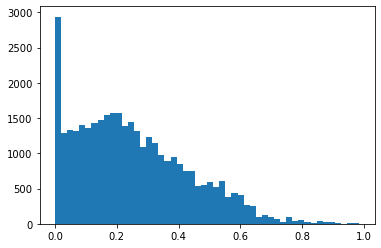

In [102]:
#scale the numerical values in dev_subset_3
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

#Salary
#max salary is 197k. to be able to interpret the coefficient easier, I will devide it by 200k

salary_scaled = dev_subset_3['Salary']/200000

plt.figure()
plt.hist(salary_scaled,bins=50)

(array([ 190.,  117.,  289.,  685.,  944., 2282., 3748., 7867., 9418.,
        4847., 4636.]),
 array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
        0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
        0.90909091, 1.        ]),
 <BarContainer object of 11 artists>)

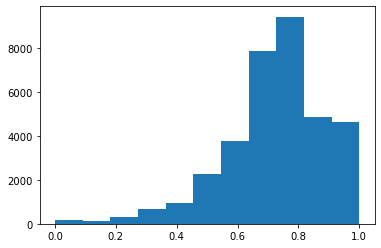

In [103]:
# scale CareerSatisfaction
#Salary
careersat_scaler = MinMaxScaler()
careersat_scaler.fit(dev_subset_3['CareerSatisfaction'].values.reshape(-1, 1))
careersat_scaled = careersat_scaler.transform(dev_subset_3['CareerSatisfaction'].values.reshape(-1, 1))

plt.figure()
plt.hist(careersat_scaled,bins=11)

(array([ 190.,  117.,  289.,  685.,  944., 2282., 3748., 7867., 9418.,
        4847., 4636.]),
 array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
        0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
        0.90909091, 1.        ]),
 <BarContainer object of 11 artists>)

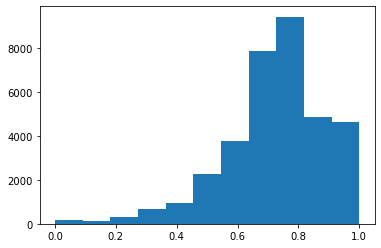

In [104]:
# scale JobSatisfaction
jobsat_scaler = MinMaxScaler()
jobsat_scaler.fit(dev_subset_3['JobSatisfaction'].values.reshape(-1, 1))
jobsat_scaled = jobsat_scaler.transform(dev_subset_3['JobSatisfaction'].values.reshape(-1, 1))

plt.figure()
plt.hist(careersat_scaled,bins=11)

In [105]:
dev_subset_3_scaled = dev_subset_3.copy()

dev_subset_3_scaled['Salary'] = salary_scaled

dev_subset_3_scaled['CareerSatisfaction'] = careersat_scaled

dev_subset_3_scaled['JobSatisfaction'] = jobsat_scaled

In [106]:
#clean the data of dev_subset_3
X_3_scaled,y_3_scaled = GetLinearRegressionInput(dev_subset_3_scaled, y_col='JobSatisfaction')

print('Salary' in X_3_scaled.columns)

X_3_scaled.shape

True


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(34955, 235)

In [107]:
# repead the linear regression
#perform linear regression
Res_3_scaled = perform_linear_regression(X_3_scaled, y_3_scaled,normal=False)

print('test score:',Res_3[0])
print('train score:',Res_3[1])

test score: 0.4204808000438004
train score: 0.42338981811516196


In [108]:
#coefficient dataframe
coeffs_3_scaled = pd.Series(Res_3_scaled[2].coef_, index=X_3_scaled.columns).sort_values(ascending = False)
coeffs_3_scaled= coeffs_3_scaled.reset_index()
salary_index = coeffs_3_scaled[coeffs_3_scaled['index'] =='Salary'].index[0]
salary_coeff = coeffs_3_scaled[coeffs_3_scaled['index'] =='Salary'].values[0]

print(coeffs_3_scaled.head(15))

print(f'{salary_index}/{len(coeffs_3_scaled)}')
print(salary_coeff)

                                                index         0
0                                  CareerSatisfaction  0.727916
1                                     Country_Denmark  0.075374
2                                     Country_Finland  0.072740
3                                 Country_Netherlands  0.063213
4                                      Country_Norway  0.062707
5                                     Country_Croatia  0.062604
6                              Country_Czech Republic  0.061334
7                                   Country_Lithuania  0.061232
8                          Country_Bosnia-Herzegovina  0.060400
9                                     Country_Vietnam  0.058307
10  DeveloperType_Web developer; Graphics programming  0.058115
11                                    Country_Hungary  0.056248
12                                     Country_Sweden  0.055601
13                                    Country_Austria  0.055392
14  DeveloperType_Embedded applications/

In [42]:
coeffs_df = coeffs_3_scaled.copy()

coeffs_df=coeffs_df.rename(columns={'index':'feature',0:'coeff'})

coeffs_df.head()

,feature,coeff
0,CareerSatisfaction,0.727916
1,Country_Denmark,0.075374
2,Country_Finland,0.072740
3,Country_Netherlands,0.063213
4,Country_Norway,0.062707


## Step 6: Evaluate the results

### Question 1: What are the most influecial factors for Job Satisfaction

In [43]:
# highest 15 coefficents

coeffs_df.head(15)

,feature,coeff
0,CareerSatisfaction,0.727916
1,Country_Denmark,0.075374
2,Country_Finland,0.072740
3,Country_Netherlands,0.063213
4,Country_Norway,0.062707
5,Country_Croatia,0.062604
6,Country_Czech Republic,0.061334
7,Country_Lithuania,0.061232
8,Country_Bosnia-Herzegovina,0.060400
9,Country_Vietnam,0.058307


In [44]:
# lowes 15 coefficients

coeffs_df.tail(15)

,feature,coeff
220,DeveloperType_Web developer; Desktop applicati...,-0.026916
221,Country_United Arab Emirates,-0.027330
222,DeveloperType_Web developer; Quality assurance...,-0.028832
223,KinshipDevelopers_Strongly disagree,-0.035446
224,DeveloperType_Database administrator,-0.037454
225,Country_Peru,-0.039388
226,DeveloperType_Machine learning specialist; Dat...,-0.040371
227,DeveloperType_Web developer; Desktop applicati...,-0.040813
228,Gender_Gender non-conforming,-0.053719
229,Country_Dominican Republic,-0.054736


### Question: How does the developer Type influences the Job satisfaction?

In [45]:
#get the 20 most frequent devloper types

dev_value_counts=dev_subset_3['DeveloperType'].value_counts()/len(dev_subset)

dev_list = dev_value_counts.sort_values(ascending=False).head(20).index

dev_type_subset = dev_subset_3[dev_subset_3['DeveloperType'].isin(dev_list)]

In [46]:
mean_job_satisfaction=dev_subset_3['JobSatisfaction'].mean()

print(mean_job_satisfaction)

7.009612358746961


In [47]:
dev_type_subset['JobSatisfactionDev']=dev_type_subset['JobSatisfaction']-mean_job_satisfaction

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [48]:
mean_career_satisfaction=dev_subset_3['CareerSatisfaction'].mean()

dev_type_subset['CareerSatisfactionDev']=dev_type_subset['CareerSatisfaction']-mean_career_satisfaction

In [49]:
dev_type_subset=dev_type_subset.groupby(by=['DeveloperType']).mean()
dev_type_subset.reset_index()
dev_type_subset.head(15)

,JobSatisfaction,Salary,CareerSatisfaction,JobSatisfactionDev,CareerSatisfactionDev
DeveloperType,,,,,
Data scientist,6.974026,46528.959397,7.177966,-0.035586,-0.269140
Desktop applications developer,6.853957,51755.255121,7.171572,-0.155656,-0.275534
Developer with a statistics or mathematics background,6.935345,61685.479037,7.129032,-0.074268,-0.318074
Embedded applications/devices developer,6.927100,56728.784602,7.346519,-0.082513,-0.100587
Embedded applications/devices developer; Desktop applications developer,6.959641,57418.867516,7.560538,-0.049971,0.113432
Mobile developer,7.063858,36381.260983,7.519421,0.054245,0.072314
Mobile developer; Desktop applications developer,6.995614,46467.338547,7.491228,-0.013998,0.044122
Other,7.162667,71874.590632,7.503979,0.153054,0.056873
Web developer,6.928338,47560.686488,7.394633,-0.081275,-0.052473


<AxesSubplot:ylabel='DeveloperType'>

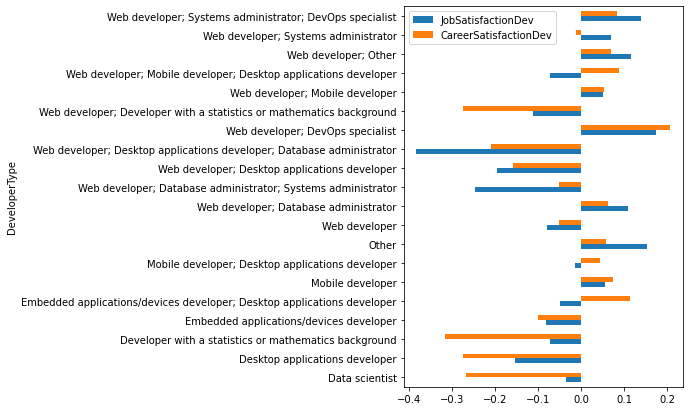

In [135]:
dev_type_subset[['JobSatisfactionDev','CareerSatisfactionDev']].plot.barh(figsize=(5,7))

### Question: What influence does the salary have on the Job satisfaction?

In [57]:
coeffs_df[coeffs_df['feature']=='Salary']

,feature,coeff
130,Salary,0.000703


This means, that an increase in Salary of 200k raises the job satisfaction of 0.0007 This is not really a lot. 

In [60]:
# introduce a Salary_class column with the opions 25%lowest, 25% highest, middle
tresh = dev_subset_3['Salary'].quantile([0.25,0.75])

print(tresh)

0.25    21343.552213
0.75    73730.186079
Name: Salary, dtype: float64
21343.55221321762


In [112]:
# add Salary_class column
dev_subset_3['Salary_class'] ='middle'

dev_subset_3['Salary_class'][dev_subset_3['Salary'] >= tresh[0.75]] = '25% highest'

dev_subset_3['Salary_class'][dev_subset_3['Salary'] <= tresh[0.25]] = '25% lowest'


<ipython-input-112-9ae8ef809e86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_subset_3['Salary_class'][dev_subset_3['Salary'] >= tresh[0.75]] = '25% highest'
<ipython-input-112-9ae8ef809e86>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_subset_3['Salary_class'][dev_subset_3['Salary'] <= tresh[0.25]] = '25% lowest'


(0.0, 0.2)

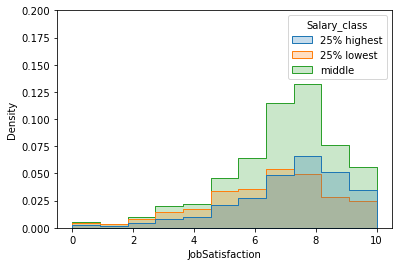

In [123]:
# plot data

sns.histplot(data=dev_subset_3,x='JobSatisfaction',hue='Salary_class',element="step",stat="density",bins=11)
plt.ylim([0,0.2])